<a href="https://colab.research.google.com/github/BADS7604Group03/assignment2/blob/main/code/Assignment2_Resnet50_unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-092ae415-0586-afaa-869c-875b2a915af1)


In [ ]:
import sys, os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2 as cv
from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [ ]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")

Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
import tensorflow as tf
tf.__version__ 

'2.8.0'

In [ ]:
#Set seed value for reproducability during experiments Skilp this cell if random initialization (with varied result) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

#Define Functions

In [ ]:
def confusionPlot(model ,x,y_true,classSeq):
  import seaborn as sns
  from sklearn import metrics

  y_pred = np.argmax(model.predict(x), axis=1)
  cf_matrix = metrics.confusion_matrix(y_true, y_pred)

  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values')

  ax.xaxis.set_ticklabels(classSeq)
  ax.yaxis.set_ticklabels(classSeq)
  plt.show()
  return cf_matrix

In [ ]:
def roc_auc(model,x_feature,y_true,classSeq):
  from sklearn.metrics import roc_curve, auc, roc_auc_score
  from sklearn.preprocessing import LabelBinarizer
  y_prob = model.predict(x_feature)
  y_label = LabelBinarizer().fit_transform(y_test)
  class_auc = []
  plt.figure(figsize=(15,5))
  for c,nam in enumerate(classSeq):
    fpr, tpr, thresholds = roc_curve(y_label[:,c], y_prob[:,c])
    class_auc.append(auc(fpr, tpr))
    plt.plot(fpr, tpr, label = f"{nam} (AUC:{class_auc[c]:0.4f})")
  
  roc_score = roc_auc_score(y_label, y_prob, average="macro")
  plt.legend()
  plt.title(f"ROC = {roc_score:0.4f}")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  return roc_score,class_auc

In [ ]:
def alter_model_for_GradCAM(model, last_conv_layer_name):
  #1) Get the output from the last convolutional layer
  last_conv_output = model.get_layer(last_conv_layer_name).output

  #2) Separate the original output layer into one prediction layer and one activation softmax layer
  ### 2.1) Copy weight of the original output layers
  old_weights = [x.numpy() for x in model.layers[-1].weights]
  ### 2.2) Copy configuration of the original layer and change where necessary
  new_config = model.layers[-1].get_config()
  new_config['activation'] = tf.keras.activations.linear    #layer's activation changed
  new_config['name'] = 'pred_linear'                           #layer's name changed
  ### 2.3 Create two new layers (linear prediction and softmax)
  out_linear = tf.keras.layers.Dense(**new_config)(model.layers[-2].output)
  out_softmax = tf.keras.activations.softmax(out_linear)

  #3) Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model(inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output])
  new_model.layers[-2].set_weights(old_weights) # Assign old weight pred_linear layer 

  return new_model

In [ ]:
def decode_prediction(preds,classDict,top_class=3):
  if preds.shape[1] != len(classDict):
    raise ValueError("Predictino and Class dict doesn't match")
  results = []
  indexs = []
  for pred in preds:
    top_indices = pred.argsort()[-top_class:][::-1]
    result = [ (i,) + (classDict[i],)+ (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[-1], reverse=True)
    indexs.append([tp[0] for tp in result ])
    results.append(result)

  return results, indexs

In [ ]:
def CNN_GradCAM(model,x_input,c):
  in_img = tf.cast(x_input ,tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model(in_img)
    one_class_score = y_linear[...,c]
  gradient = tape.gradient( one_class_score, last_conv_activation) 
  
  gradient = gradient.numpy().squeeze(axis=0)
  alpha = np.mean(gradient ,axis=(0,1)) 
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
  heatmap = np.dot(last_conv_activation,alpha)
  heatmap = np.maximum(0 ,heatmap)

  return heatmap

# Load Data

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/BADS7604_Deep_Learning/Project2/source"

x_image = np.load(path+"/x_image_224_224.npy" )
y_image = np.load(path+"/y_image.npy"  )
class_dict = {i:nam for i,nam in enumerate(np.load(path+"/class_seq.npy" ))}

In [ ]:
num_class,num_member = np.unique(y_image, return_counts=True)
{'class':[class_dict[i] for i in num_class] 
,'Image':num_member}

{'Image': array([200, 200, 200]), 'class': ['atmosphere', 'food', 'menu']}

In [ ]:
x_train, x_test, y_train, y_test = train_test_split( x_image, y_image, test_size=0.2, random_state=1234)

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}\n")
print( f"y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train):.4f} ,max(y_train)={np.max(y_train):.4f}")
print( f"y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test):.4f} ,max(y_test)={np.max(y_test):.4f}")

x_train.shape=(480, 224, 224, 3), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(120, 224, 224, 3), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=255.0000

y_train.shape=(480,), y_train.dtype=float64, min(y_train)=0.0000 ,max(y_train)=2.0000
y_test.shape=(120,), y_test.dtype=float64, min(y_test)=0.0000 ,max(y_test)=2.0000


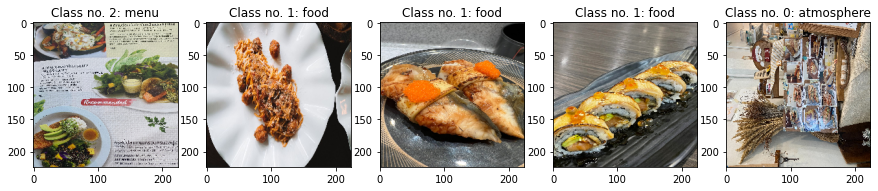

In [ ]:
#Visulize the first image in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150+1+i).set_title(f"Class no. {int(y_train[i])}: {class_dict[int(y_train[i])]}")
  plt.imshow( x_train[i].astype(np.uint8))
plt.show()

In [ ]:
# Preprocess dataset to match NASNetMobile's requirement
x_train_resnet50 = tf.keras.applications.resnet50.preprocess_input(x_train.copy())
x_test_resnet50 =tf.keras.applications.resnet50.preprocess_input(x_test.copy())

print( f"x_train_nasnet shape={x_train_resnet50.shape}, dtype={x_train_resnet50.dtype}, min={np.min(x_train_resnet50):.4f} ,max={np.max(x_train_resnet50):.4f}")
print( f"x_test_nasnet shape={x_test_resnet50.shape}, dtype={x_test_resnet50.dtype}, min={np.min(x_test_resnet50):.4f} ,max={np.max(x_test_resnet50):.4f}")

x_train_nasnet shape=(480, 224, 224, 3), dtype=float32, min=-123.6800 ,max=151.0610
x_test_nasnet shape=(120, 224, 224, 3), dtype=float32, min=-123.6800 ,max=151.0610


# Load the pretrined model (Only Feature extractor)

In [ ]:
extractor_resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

#Freeze weights all layers in the model
#extractor_resnet50.trainable = False


#Unfreeze last Layer:conv5_block3_3_conv
for layer in extractor_resnet50.layers[:171]:
    layer.trainable = False

print(f"model input shape : {extractor_resnet50.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(extractor_resnet50.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in extractor_resnet50.layers])}")

extractor_resnet50.summary()

model input shape : (None, 224, 224, 3)
Total Layer in Model : 175
Total Training Layer : 4
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 

In [ ]:
#Print Layer detail
for i,j_layer in enumerate(extractor_resnet50.layers):
  print(f"Layer {i} {j_layer}: name = {j_layer.name}, trainable = {j_layer.trainable}")

Layer 0 <keras.engine.input_layer.InputLayer object at 0x7fc9535c4050>: name = input_3, trainable = False
Layer 1 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc958a49150>: name = conv1_pad, trainable = False
Layer 2 <keras.layers.convolutional.Conv2D object at 0x7fc9ccf32d50>: name = conv1_conv, trainable = False
Layer 3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc9cd8ca890>: name = conv1_bn, trainable = False
Layer 4 <keras.layers.core.activation.Activation object at 0x7fc958a42250>: name = conv1_relu, trainable = False
Layer 5 <keras.layers.convolutional.ZeroPadding2D object at 0x7fca40721a50>: name = pool1_pad, trainable = False
Layer 6 <keras.layers.pooling.MaxPooling2D object at 0x7fca4030c550>: name = pool1_pool, trainable = False
Layer 7 <keras.layers.convolutional.Conv2D object at 0x7fc9cca76090>: name = conv2_block1_1_conv, trainable = False
Layer 8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7

In [ ]:
# last_layer = extractor_resnet50.get_layer('conv5_block3_3_conv') #get the layer
# last_output = last_layer.output                          #get the layer output
# x = tf.keras.layers.Flatten()(last_output)               #flatten the output
# x = tf.keras.layers.Dense(256, activation='relu')(x)    #add your own layers
# x = tf.keras.layers.Dense(256, activation='sigmoid')(x)    #add your own output
# x = tf.keras.layers.Dropout(0.5)(x)
# model = tf.keras.Model(extractor_resnet50.input, x)              #create the new model

In [ ]:
#Print Layer detail
for i,j_layer in enumerate(extractor_resnet50.layers):
  print(f"Layer {i} {j_layer}: name = {j_layer.name}, trainable = {j_layer.trainable}")

Layer 0 <keras.engine.input_layer.InputLayer object at 0x7fc9535c4050>: name = input_3, trainable = False
Layer 1 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc958a49150>: name = conv1_pad, trainable = False
Layer 2 <keras.layers.convolutional.Conv2D object at 0x7fc9ccf32d50>: name = conv1_conv, trainable = False
Layer 3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc9cd8ca890>: name = conv1_bn, trainable = False
Layer 4 <keras.layers.core.activation.Activation object at 0x7fc958a42250>: name = conv1_relu, trainable = False
Layer 5 <keras.layers.convolutional.ZeroPadding2D object at 0x7fca40721a50>: name = pool1_pad, trainable = False
Layer 6 <keras.layers.pooling.MaxPooling2D object at 0x7fca4030c550>: name = pool1_pool, trainable = False
Layer 7 <keras.layers.convolutional.Conv2D object at 0x7fc9cca76090>: name = conv2_block1_1_conv, trainable = False
Layer 8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7

#Add a new classification head

In [ ]:
x = extractor_resnet50.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(512 ,activation='relu')(x)
x = tf.keras.layers.Dense(256 ,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=extractor_resnet50.input, outputs=new_outputs)
#model.summary()

print(f"model input shape : {model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(model.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in model.layers])}")
model.summary()

model input shape : (None, 224, 224, 3)
Total Layer in Model : 181
Total Training Layer : 10
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 

#Data Augmentation

In [ ]:
#Create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
train_datagen.fit(x_train_resnet50)

===== Train batch no. 1/3 =====


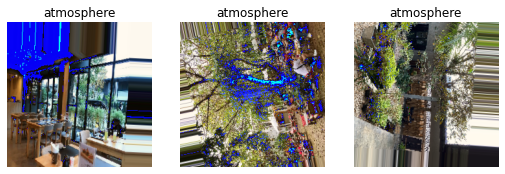

===== Train batch no. 2/3 =====


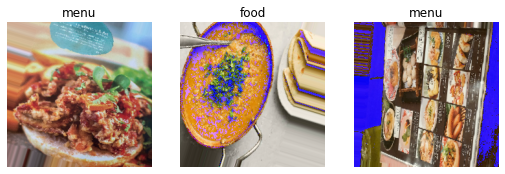

===== Train batch no. 3/3 =====


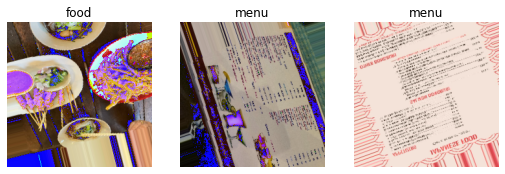

In [ ]:
from IPython.core.pylabtools import figsize
# Visualize some Training Image from the ImageDataGenerator
img_shape = x_train_resnet50.shape[1:]
n_show = 3
for b, (x_batch, y_batch) in enumerate( train_datagen.flow(x_train, y_train, batch_size=n_show ,subset='training')):
  print(f"{'='*5} Train batch no. {b+1}/{n_show} {'='*5}")
  plt.figure(figsize=(15,5))
  for i in range(n_show):
    plt.subplot(150+1+i).set_title(class_dict[int(y_batch[i])])
    plt.imshow(x_batch[i].astype(np.uint8).reshape(img_shape) , cmap='gray')
    plt.axis('off') #Remove all tick marks
  plt.show()
  if b+1 >= n_show:
    break

#Train the model with transfer learning
No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
#Check Save path and cleaning  
save_path = "./bestModel/"
if os.path.isdir(save_path):
  os.system(f"rm {save_path}*.hdf5")
else :
  os.system(f"mkdir {save_path}")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="Nadam", metrics=["acc"])

In [ ]:
checkpoint_filepath = "bestModel/bestmodel_loss{val_loss:.2f}_epoch{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                               save_weights_only=False, 
                                                               monitor='val_acc', 
                                                               model='max', 
                                                               save_best_only=True)

In [ ]:
# K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(train_datagen.flow(x_train_resnet50, y_train, batch_size=128, subset="training"),
                    epochs=50, verbose=1,
                    validation_data=train_datagen.flow(x_train_resnet50, y_train, subset="validation"),
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
3/3 [==============================] - 15s 4s/step - loss: 14.3666 - acc: 0.3411 - val_loss: 14.2137 - val_acc: 0.3333
Epoch 2/50
3/3 [==============================] - 9s 3s/step - loss: 9.6612 - acc: 0.5677 - val_loss: 1.2984 - val_acc: 0.8438
Epoch 3/50
3/3 [==============================] - 9s 3s/step - loss: 2.0691 - acc: 0.7682 - val_loss: 0.5594 - val_acc: 0.8958
Epoch 4/50
3/3 [==============================] - 9s 3s/step - loss: 0.3520 - acc: 0.9297 - val_loss: 0.5896 - val_acc: 0.9271
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.3504 - acc: 0.9609 - val_loss: 0.5934 - val_acc: 0.9271
Epoch 6/50
3/3 [==============================] - 9s 3s/step - loss: 0.2225 - acc: 0.9635 - val_loss: 0.4568 - val_acc: 0.9375
Epoch 7/50
3/3 [==============================] - 8s 3s/step - loss: 0.1286 - acc: 0.9714 - val_loss: 0.5787 - val_acc: 0.9167
Epoch 8/50
3/3 [==============================] - 8s 3s/step - loss: 0.0979 - acc: 0.9792 - val_loss: 0.5484

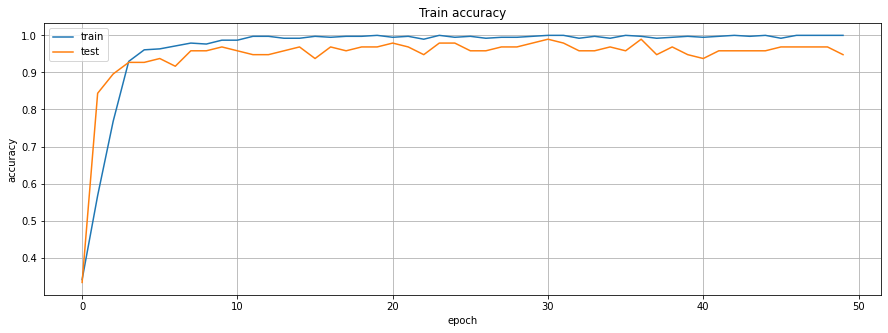

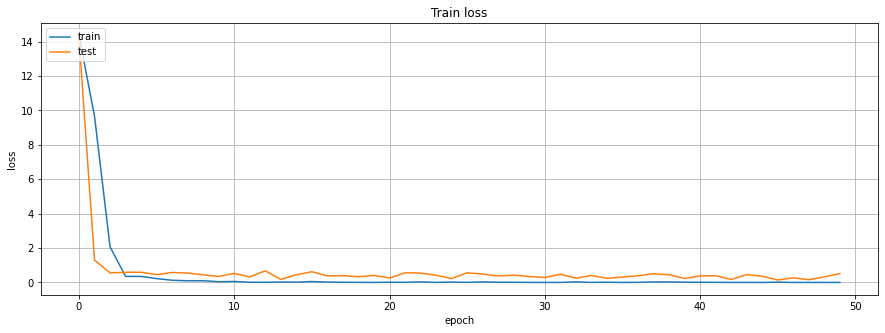

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Train accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

#Get Best Model From file and Save best model to google drive

In [ ]:
#Get model best loss from file
best_loss = np.sort(np.array(os.listdir(save_path)))[0]
print(best_loss)

bestmodel_loss0.26_epoch21.hdf5


In [ ]:
#Save file best model to google drive
from_path = f"{save_path}{best_loss}"
to_path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604_Deep_Learning/Project2/bestModel/resnet50_{best_loss[10:]}"
print(f"from : {from_path}")
print(f"to : {to_path}")
os.system(f"cp '{from_path}' '{to_path}'")

from : ./bestModel/bestmodel_loss0.26_epoch21.hdf5
to : /content/drive/MyDrive/Colab Notebooks/BADS7604_Deep_Learning/Project2/bestModel/resnet50_loss0.26_epoch21.hdf5


0

In [ ]:
# Load Best Model from file
best_model = tf.keras.models.load_model(save_path+best_loss ,compile=True)
print(f"Model from file : {save_path}{best_loss}")
print(f"model input shape : {best_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(best_model.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in best_model.layers])}")

Model from file : ./bestModel/bestmodel_loss0.26_epoch21.hdf5
model input shape : (None, 224, 224, 3)
Total Layer in Model : 181
Total Training Layer : 11


#Evaluation

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_resnet50, y_test, batch_size=128)
print(f"{model.metrics_names}: {results}")

1/1 [==============================] - 2s 2s/step - loss: 0.7403 - acc: 0.9500
['loss', 'acc']: [0.7403056621551514, 0.949999988079071]


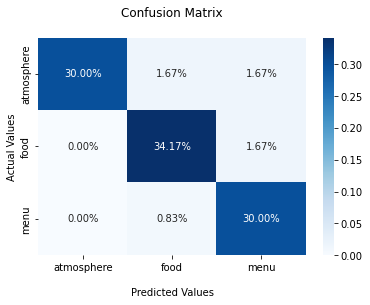

In [ ]:
cf_matrix = confusionPlot(best_model, x_test_resnet50, y_test, class_dict.values())

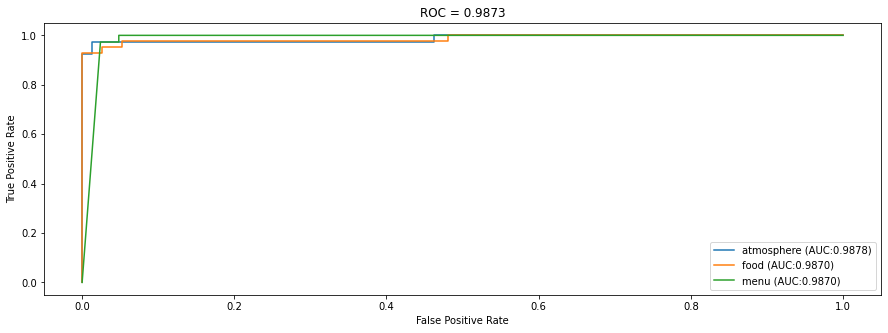

In [ ]:
roc_score,lst_auc = roc_auc(best_model,x_test_resnet50,y_test, class_dict.values())

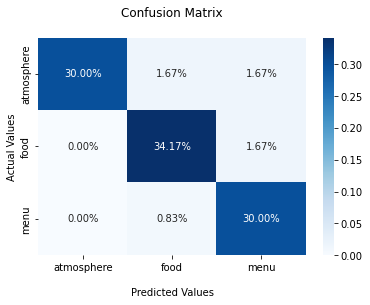

atmosphere : 0.9
food : 0.9534883720930233
menu : 0.972972972972973
Total Accuracy : 0.9416666666666667


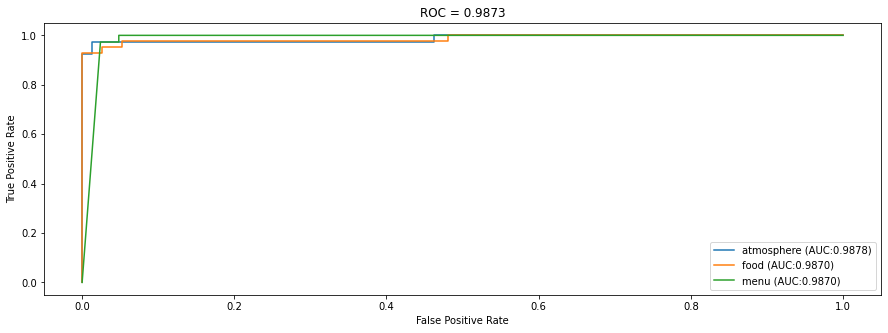

roc_score : 0.9872668045823166
atmosphere : 0.9878125
food : 0.9870129870129869
menu : 0.9869749267339628


In [ ]:
cf_matrix = confusionPlot(best_model, x_test_resnet50, y_test, class_dict.values())
for i in range(3):
  print(f"{class_dict[i]} : {cf_matrix[i,i]/cf_matrix[i,:].sum()}")
print(f"Total Accuracy : {cf_matrix.diagonal().sum()/cf_matrix.sum()}")


roc_score,lst_auc = roc_auc(best_model,x_test_resnet50,y_test, class_dict.values())
print(f"roc_score : {roc_score}")
for i in range(3):
  print(f"{class_dict[i]} : {lst_auc[i]}")

#Inference

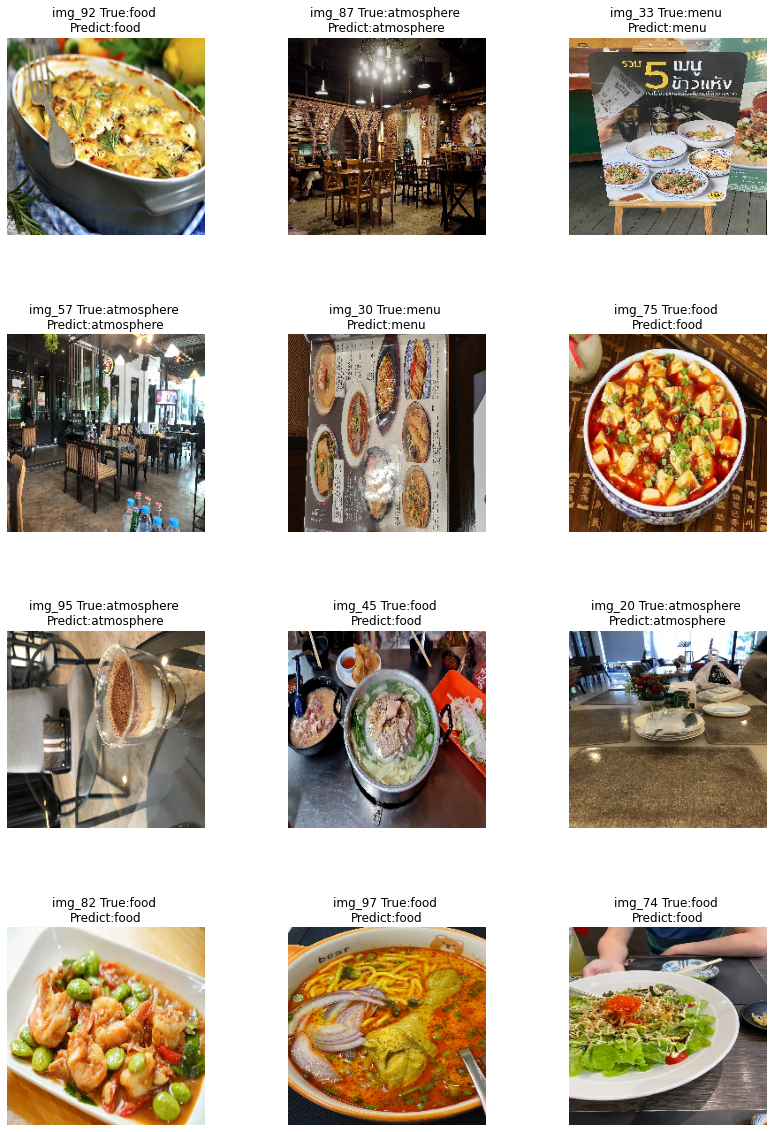

In [ ]:
fig, axs = plt.subplots(4,3, figsize=(15, 20))
fig.subplots_adjust(hspace = .5, wspace=.02)
axs = axs.ravel()

for i,idx in enumerate(np.random.choice(x_test_resnet50.shape[0] ,12)):
  y_pred = best_model.predict(x_test_resnet50[idx].reshape(1,224, 224, 3))
  axs[i].imshow( x_test[idx].astype(np.uint8))
  axs[i].set_title(f"img_{idx} True:{class_dict[int(y_test[idx])]} \nPredict:{class_dict[np.argmax(y_pred)]}")
  axs[i].axis('off')
plt.show()

#Fix Output Layer and Get weight in Last Convolutional Layer

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
new_model = alter_model_for_GradCAM(best_model, 'conv5_block3_2_conv')

print(f"model input shape : {new_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(new_model.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in new_model.layers])}")
print(f"Input layer : {new_model.input_names}")
print(f"Output layer: {new_model.output_names}")

model input shape : (None, 224, 224, 3)
Total Layer in Model : 182
Total Training Layer : 12
Input layer : ['input_3']
Output layer: ['tf.nn.softmax_2', 'pred_linear', 'conv5_block3_2_conv']


In [ ]:
#Test Prediction 
img_index = np.random.choice(x_test_resnet50.shape[0] ,1)
img_test = x_test_resnet50[img_index].reshape(-1,224, 224, 3)
img_test_ori = x_test[img_index][0]
out_softmax,out_liner,_ = new_model.predict(img_test)

In [ ]:
tops = 3
result_decodes,result_indexs = decode_prediction(out_softmax, class_dict, tops)
print(f"Result of decode \n {result_decodes}")
print(f"Result of index \n {result_indexs}")

Result of decode 
 [[(1, 'food', 1.0), (0, 'atmosphere', 6.504553e-13), (2, 'menu', 1.4842207e-15)]]
Result of index 
 [[1, 0, 2]]


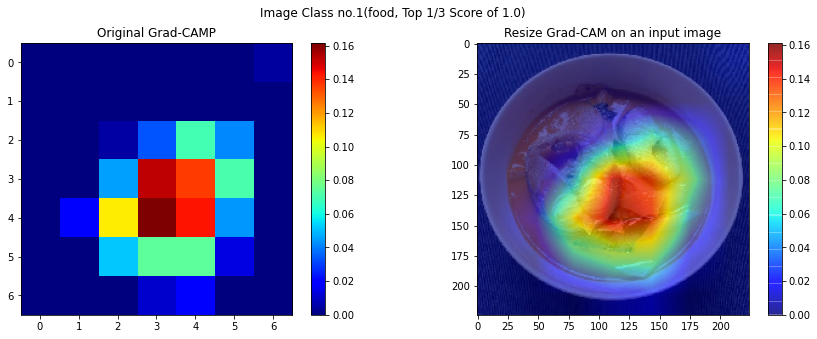

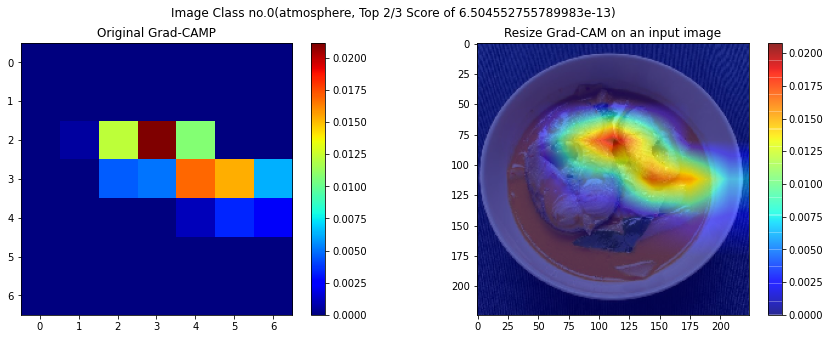

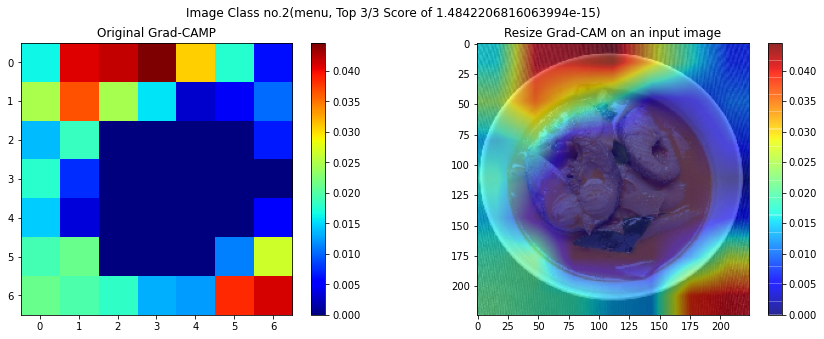

In [ ]:
for i,c in enumerate(result_indexs[0]):
  heatmap = CNN_GradCAM(new_model,  img_test, c )
  #Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = f"{class_dict[c]}, Top {i+1}/{tops} Score of {out_softmax[...,c].squeeze()}"
  fig.suptitle(f"Image Class no.{c}({class_desc})")
  # Visualize the Original Heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title('Original Grad-CAMP')
  im = ax.imshow( heatmap ,cmap='jet')
  plt.colorbar(im, ax=ax)

  #Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title('Resize Grad-CAM on an input image')
  ax.imshow(img_test_ori.astype(np.uint8))
  alpha = 0.6
  im = ax.imshow(cv.resize( heatmap, img_test_ori.shape[:2]), cmap='jet', alpha=alpha )
  plt.colorbar(im, ax=ax)

  plt.show()

In [ ]:
out_softmax,out_liner,_ = new_model.predict(x_test_resnet50)
idx_mx_prob = []
for i in range(0,out_softmax.shape[1]):
  idx_mx_prob.append(np.argmax(out_softmax[:,i]))
print(idx_mx_prob)

[3, 5, 0]


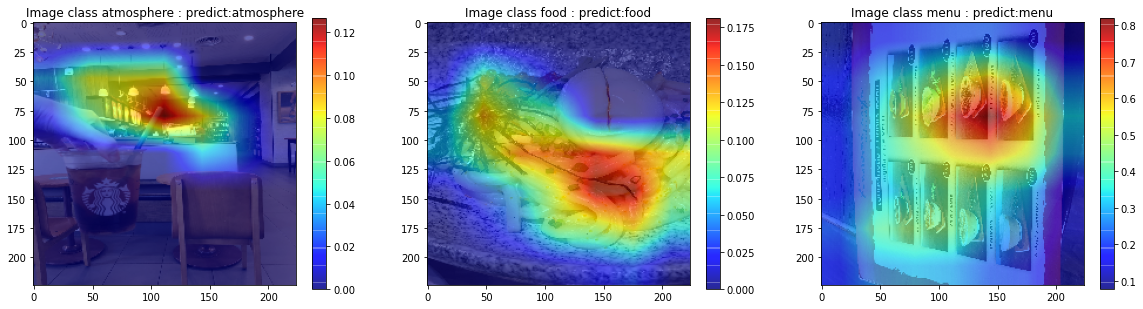

In [ ]:
fig = plt.figure( figsize=(20,5))
for c,idx in enumerate(idx_mx_prob):
  img_mx_input = x_test_resnet50[idx].reshape(-1,224, 224, 3)
  img_mx_origi = x_test[idx]
  true_class = int(y_test[idx])
  mx_softmax,mx_liner,_ = new_model.predict(img_mx_input)
  mx_decodes,mx_indexs = decode_prediction(mx_softmax, class_dict, 1)
  predict_class = mx_indexs[0][0]

  mx_heatmap = CNN_GradCAM(new_model, img_mx_input, predict_class )

  #Create the main figure
  ax = fig.add_subplot(1, 3, c+1)
  ax.set_title(f"Image class {class_dict[true_class]} : predict:{class_dict[predict_class]}")
  ax.imshow(img_mx_origi.astype(np.uint8))
  im = ax.imshow(cv.resize( mx_heatmap, img_mx_origi.shape[:2]), cmap='jet', alpha=0.6 )
  plt.colorbar(im, ax=ax)

plt.show()